# Probabilistic modelling: NGBoost and PyMC3

Probabilistic modelling, is the approach where the model outputs a full probability distribution over the entire outcome space. It is a natural way to quantify uncertainties in ML models.

Compare the point predictions vs probabilistic predictions in the following examples.

![title](images/prob_modelling.png)

Probabilistic modelling has been made much easier recently with packages as NGBoost or PyCM3.

In this Notebook we:

- introduce NGBoost and show the simplcity of its useage
- compare NGBoost with PyMC3
- introduce metrics to compare probabilistic models

# 1. NGBoost

[NGBoost](https://stanfordmlgroup.github.io/projects/ngboost/) has been introduced at ICML 2020. It supports a sklearn interface and makes it very easy to perform probabilistic modelling.

We will illustrate its useage on the Boston bikeshare dataset, in which we are tasked to predict how many bikes are hired.

Ready? Let's ride!

![title](images/bikeshare.jpg)

In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from ngboost import NGBRegressor
from ngboost.distns import Normal

## 1.1 Load data

In [2]:
def load_bikeshare():
    # Source: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset
    data = pd.read_csv("data/hour.csv")

    # Drop dteday: captured in yr,mnth,hr features
    # Drop features casual and registered, captured in cnt, which is the cumalative sum
    X = data.iloc[:, 2:-3]
    X = X.drop("temp", axis=1)
    y = data.iloc[:, -1]

    return X, y


X, y = load_bikeshare()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [3]:
X.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.2879,0.81,0.0
1,1,0,1,1,0,6,0,1,0.2727,0.80,0.0
2,1,0,1,2,0,6,0,1,0.2727,0.80,0.0
3,1,0,1,3,0,6,0,1,0.2879,0.75,0.0
4,1,0,1,4,0,6,0,1,0.2879,0.75,0.0


In [4]:
y.head()

0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64

## 1.2. Train and compare models

We  train and compare the error of the following models:

- Linear Regression
- Random Forest
- Gradient Boosting
- NGBoost

Note the following:

- The error metric of NGBoost is comparable to the one of Gradient Boosting
- The syntax for training NGBoost is the same as sklearn

In [5]:
gb = GradientBoostingRegressor(n_estimators=100, loss="huber")
gb.fit(X_train, y_train)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

ngb = NGBRegressor(Dist=Normal)
ngb.fit(X_train, y_train)

[iter 0] loss=6.6268 val_loss=0.0000 scale=1.0000 norm=143.2498
[iter 100] loss=6.1383 val_loss=0.0000 scale=2.0000 norm=176.7223
[iter 200] loss=5.7548 val_loss=0.0000 scale=2.0000 norm=136.4625
[iter 300] loss=5.5472 val_loss=0.0000 scale=1.0000 norm=61.3906
[iter 400] loss=5.4474 val_loss=0.0000 scale=2.0000 norm=117.3536


NGBRegressor(random_state=RandomState(MT19937) at 0x10EC78360)

In [6]:
res = {}
res["Linear Regression"] = {
    "MAE Train": mean_absolute_error(y_train, lr.predict(X_train)),
    "MAE Test": mean_absolute_error(y_test, lr.predict(X_test)),
}

res["Random Forest"] = {
    "MAE Train": mean_absolute_error(y_train, rf.predict(X_train)),
    "MAE Test": mean_absolute_error(y_test, rf.predict(X_test)),
}

res["Gradient Boosting"] = {
    "MAE Train": mean_absolute_error(y_train, gb.predict(X_train)),
    "MAE Test": mean_absolute_error(y_test, gb.predict(X_test)),
}

res["NGBoost"] = {
    "MAE Train": mean_absolute_error(y_train, ngb.predict(X_train)),
    "MAE Test": mean_absolute_error(y_test, ngb.predict(X_test)),
}

pd.DataFrame(res).T.sort_values("MAE Test", ascending=True).round(2)

,MAE Train,MAE Test
Random Forest,9.87,25.57
Gradient Boosting,49.50,48.50
NGBoost,56.97,55.75
Linear Regression,106.89,105.22


## 1.2. Probabilistic prediction

Doing point prediction is possible and follows sklearn synax:

In [7]:
print("Prediction of first test data point:")
print(f"Random Forest: {rf.predict(X_test.head(1))[0]}")
print(f"Gradient Boosting: {rf.predict(X_test.head(1))[0]}")
print(f"NGBoost: {ngb.predict(X_test.head(1))[0]}")

Prediction of first test data point:
Random Forest: 384.13
Gradient Boosting: 384.13
NGBoost: 465.0774664416433


The added-value of NGBoost is the capacity to give a probabilistic prediction:

- The familly of the distribution is defined before fitting the model (here we used a Normal diistribution)
- The parameters of the distribution are given by `pred_dist`

In [8]:
print("Distribution parameters of first test data point:")
print(f"Mean: {ngb.pred_dist(X_test.head(1)).params['loc'][0]}")
print(f"Scale: {ngb.pred_dist(X_test.head(1)).params['scale'][0]}")

Distribution parameters of first test data point:
Mean: 465.0774664416433
Scale: 121.45456299268858


We can compare the predictions graphically:

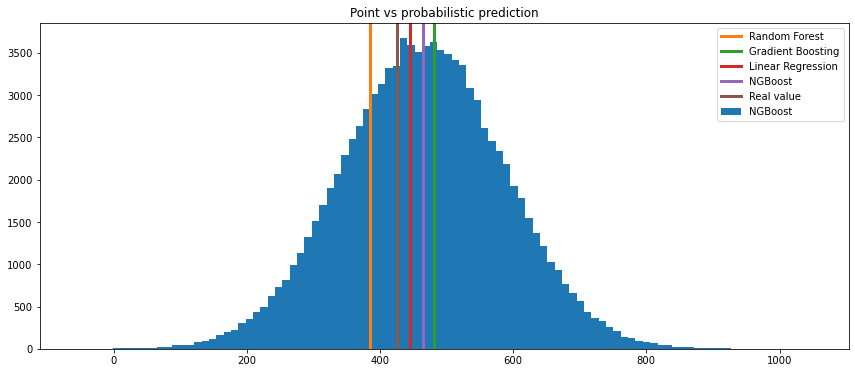

In [9]:
data_id = 0

dict_point_prediction = {
    "Random Forest": rf.predict(X_test.iloc[[data_id], :]),
    "Gradient Boosting": gb.predict(X_test.iloc[[data_id], :]),
    "Linear Regression": lr.predict(X_test.iloc[[data_id], :]),
    "NGBoost": ngb.predict(X_test.iloc[[data_id], :]),
    "Real value": y_test.iloc[data_id],
}

fig, ax = plt.subplots(figsize=(14.5, 6))

plt.hist(
    np.random.normal(
        loc=ngb.pred_dist(X_test.iloc[[data_id], :]).params["loc"],
        scale=ngb.pred_dist(X_test.iloc[[data_id], :]).params["scale"],
        size=100000,
    ),
    100,
    label="NGBoost",
    color=next(ax._get_lines.prop_cycler)["color"],
)

for name, prediction in dict_point_prediction.items():
    ax.axvline(
        x=prediction,
        label=name,
        color=next(ax._get_lines.prop_cycler)["color"],
        linewidth=3,
    )

plt.title("Point vs probabilistic prediction")
plt.legend()
plt.show()

# 2. PyMC3

[PyMC3](https://docs.pymc.io/) is a package that allows to perform Bayesian prediction easily. However, as we see bellow, it requires more effort than NGBoost.

We will use a Bayesian linear regression, with:

- some feature engineering (ex: take the sin of temporal features)
- normal priors
- negative binomial likelihood

In [10]:
# Feature engineering for the Bayesian model
X_train_input = X_train.copy()
X_test_input = X_test.copy()

# OHE
X_train_input = pd.get_dummies(X_train_input, drop_first=True, columns=["season", "yr"])
X_test_input = pd.get_dummies(X_test_input, drop_first=True, columns=["season", "yr"])

# Take sin of month, hour and holiday
for col in ["mnth", "hr", "weekday"]:
    X_train_input["sin_{}".format(col)] = np.sin(
        2 * np.pi * X_train_input[col] / X_train_input[col].max()
    )
    X_train_input["cos_{}".format(col)] = np.cos(
        2 * np.pi * X_train_input[col] / X_train_input[col].max()
    )
    X_train_input = X_train_input.drop(columns=[col])

    X_test_input["sin_{}".format(col)] = np.sin(
        2 * np.pi * X_test_input[col] / X_test_input[col].max()
    )
    X_test_input["cos_{}".format(col)] = np.cos(
        2 * np.pi * X_test_input[col] / X_test_input[col].max()
    )
    X_test_input = X_test_input.drop(columns=[col])

# Normalise data
scaler = StandardScaler().fit(X_train_input)

X_train_input = pd.DataFrame(
    scaler.transform(X_train_input), columns=X_train_input.columns
)
X_test_input = pd.DataFrame(
    scaler.transform(X_test_input), columns=X_test_input.columns
)

In [11]:
# Define the model
import pymc3 as pm

features = X_train_input.columns

with pm.Model() as model:
    # Define data
    data_train = dict()
    for feat in features:
        data_train[feat] = pm.Data("x_{}".format(feat), X_train_input[feat])

    # Define priors
    coeffs = [pm.Normal("Intercept", mu=0, sigma=5)]
    for feat in features:
        coeffs.append(pm.Normal(feat, mu=0, sigma=1))

    # define linear model and exp link function
    theta = coeffs[0]
    for nb_feat, feat in enumerate(features):
        theta += coeffs[nb_feat + 1] * data_train[feat]

    # Define alpha for Negative Binomial
    alpha = pm.HalfNormal("alpha", sigma=10)

    ## Define likelihood
    y = pm.NegativeBinomial("y", mu=np.exp(theta), alpha=alpha, observed=y_train.values)

In [12]:
# Fit the model
with model:
    trace = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, cos_weekday, sin_weekday, cos_hr, sin_hr, cos_mnth, sin_mnth, yr_1, season_4, season_3, season_2, windspeed, hum, atemp, weathersit, workingday, holiday, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.


/anaconda3/envs/optimisation/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weathersit'}>,
        <AxesSubplot:title={'center':'weathersit'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'hum'}>,
        <AxesSubplot:title={'center':'hum'}>],
       [<AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'season_2'}>,
        <AxesSubplot:title={'center':'season_2'}>],
       [<AxesSubplot:title={'center':'season_3'}>,
        <AxesSubplot:title={'center':'season_3'}>],
       [<AxesSubplot:title={'center':'season_4'}>,
        <AxesSubplot:title={

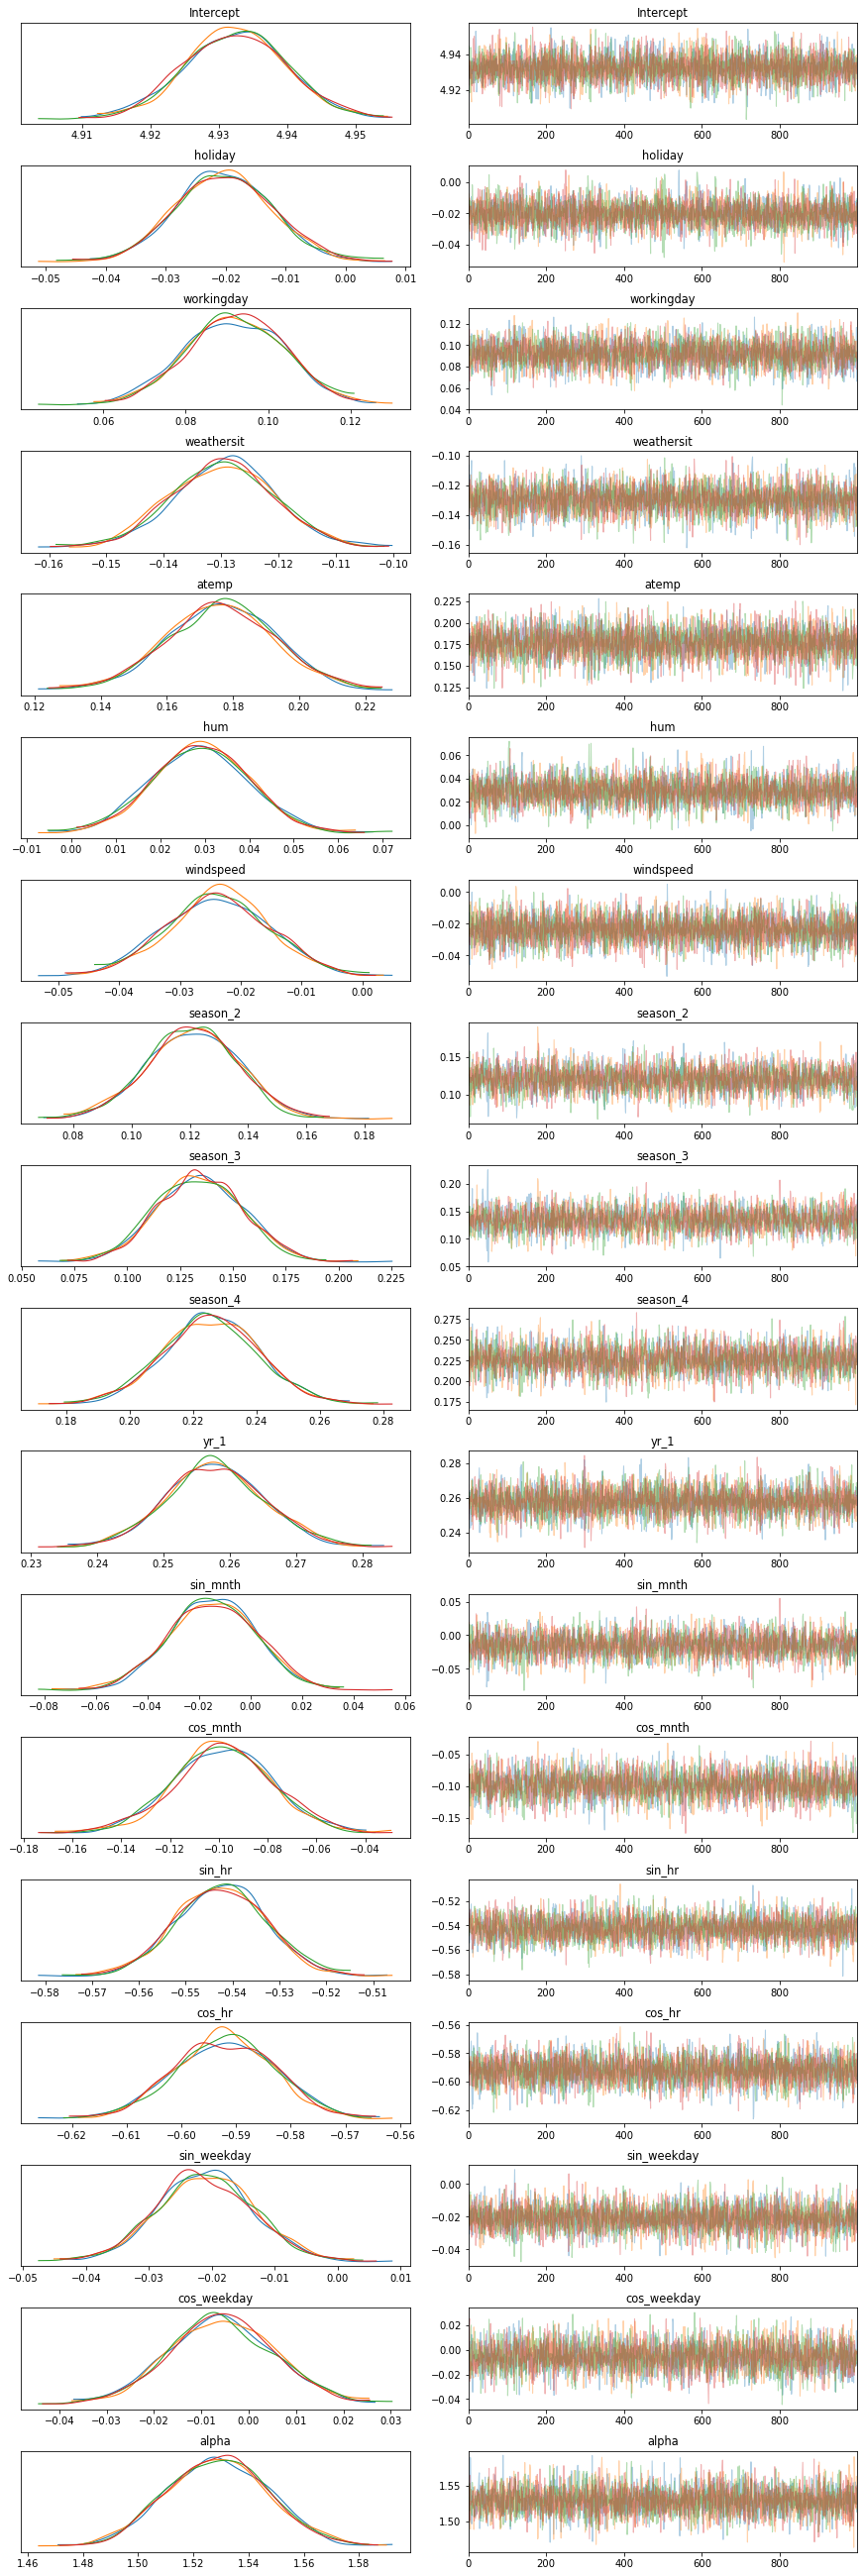

In [13]:
# Check trace
import arviz as az

az.plot_trace(trace)

In [14]:
# Prediction on train set
with model:
    posterior_samples = pm.sample_posterior_predictive(trace)

# Prediction on test set
with model:
    for feat in features:
        pm.set_data({"x_{}".format(feat): X_test_input[feat]})

    post_pred = pm.sample_posterior_predictive(trace)

We can now compare the probabilistic prediction of PyMC3 and NGBoost. We can see that:

- NGBoost distribution is Gaussian while PyMC3 looks more like a negative binomial. This is due to the assumptions we took for each of the models
- On this example NGBoost has a better prediction as the mean of its distribution is close to the real observed value

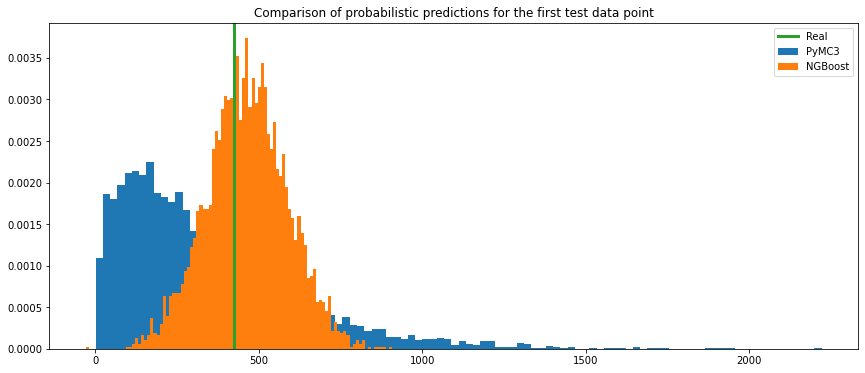

In [15]:
data_id = 0

y_draws_ngboost = np.random.multivariate_normal(
    mean=ngb.pred_dist(X_test).params["loc"],
    cov=np.diag(ngb.pred_dist(X_test).params["scale"] ** 2),
    size=4000,
)

fig, ax = plt.subplots(figsize=(14.5, 6))

plt.hist(
    post_pred["y"][:, data_id],
    label="PyMC3",
    color=next(ax._get_lines.prop_cycler)["color"],
    density=True,
    bins=100,
)


plt.hist(
    y_draws_ngboost[:, data_id],
    label="NGBoost",
    color=next(ax._get_lines.prop_cycler)["color"],
    density=True,
    bins=100,
)

ax.axvline(
    y_test.iloc[data_id],
    label="Real",
    color=next(ax._get_lines.prop_cycler)["color"],
    linewidth=3,
)

plt.title("Comparison of probabilistic predictions for the first test data point")
plt.legend()
plt.show()

## 3. Compare probabilistic models

How can we compare the goodness of fit for probabilistic models?

- **Pointwise prediction errors** (like MAE, RMSE, etc.) only compare the expectation of the predited distribution to the real value. As such, they are not informative about the shape of the distribution - imagine two distributions, both centered on the same point, but one distribution with a much larger variance than the other; those distributions will have the same MAE although they convey very different stories
- **The empirical coverage** computes which proportion of the test points fall outside of the $\alpha$ confidence bounds (typically $\alpha$ is taken as 80%, 90% or 95%): if this proporion is $\alpha$, then the model is well parameterized.

    - It is easy to define the $\alpha$ confidence bounds for symetric distribution (ex: normal), by taking the $\frac{\alpha}{2}$ quantile interval around the mean.
    - However, for non-symetric distribution (ex: negative binomial), it is not obvious how to define it - in the following we compute it by taking the $\alpha$ interval starting from the minimum of the distribution.
    - Hence, this metric is easy to inteerpret, but it can be complex to implement.
- **The log-likelihood** is defined as $\sum_i log(p(x_i))$ where $p(x_i)$ is the probability of the test data $x_i$ according to the model. The higher the log-likelihood, the better the model (the best one being 0, when $p(x_i)=1$ for all test data points).

In the cells bellow we implment those metrics to compare our NGBoost and PyMC3 models on the test set. We see that:

- NGBoost has a better estimation of the mean (MAE)
- However NGBoost tends to overestimate its uncertainty (empirical average)
- Overall, NGBoost has a better fit on the Boston dataset (log-likelihood)

## 3.1 Point-wise error metric

In [16]:
res["Bayes"] = {
    "MAE Train": mean_absolute_error(y_train, posterior_samples["y"].mean(axis=0)),
    "MAE Test": mean_absolute_error(y_test, post_pred["y"].mean(axis=0)),
}

pd.DataFrame(res).T.sort_values("MAE Test", ascending=True).round(2)

,MAE Train,MAE Test
Random Forest,9.87,25.57
Gradient Boosting,49.50,48.50
NGBoost,56.97,55.75
Linear Regression,106.89,105.22
Bayes,112.14,112.11


## 3.2 Empirical coverage

In [17]:
def empirical_coverage(y_sample, y, interval=0.95, distribution="centered"):
    if y_sample.shape[1] != y.shape[0]:
        raise ValueError(
            "y_sample should be of dimenssion (nb_samples * nb_points), with nb_points the shape of y"
        )

    if distribution == "centered":
        alpha = (1 - interval) / 2
        lower_quantile = np.quantile(y_sample, alpha / 2, axis=0)
        upper_quantile = np.quantile(y_sample, 1 - alpha / 2, axis=0)

    elif distribution == "min":
        lower_quantile = np.min(y_sample, axis=0)
        upper_quantile = np.quantile(y_sample, interval, axis=0)

    else:
        raise ValueError(
            "distribution should be `centered` or `min`, got {}".format(distribution)
        )

    return sum((lower_quantile <= y) & (y <= upper_quantile)) / len(y_test)

In [18]:
coverage = dict()
covarge_values = [80, 90, 95, 99]

coverage["Bayes"] = dict()
coverage["NGBoost"] = dict()
for covarge_value in covarge_values:
    dict_key = "coverage {}".format(covarge_value)
    coverage["Bayes"][dict_key] = empirical_coverage(
        post_pred["y"],
        y_test,
        interval=covarge_value * 0.01,
        distribution="min",
    )

    coverage["NGBoost"][dict_key] = empirical_coverage(
        y_draws_ngboost,
        y_test,
        interval=covarge_value * 0.01,
        distribution="centered",
    )

pd.DataFrame(coverage).T

,coverage 80,coverage 90,coverage 95,coverage 99
Bayes,0.819561,0.929219,0.955195,0.986750
NGBoost,0.949442,0.978731,0.989888,0.998257


## 3.3 Log-loss

In [19]:
log_loss = dict()
log_loss["log-loss"] = dict()

In [20]:
# Compute log-loss for NGBoost

pred = []

locs = ngb.pred_dist(X_test).params["loc"]
scales = ngb.pred_dist(X_test).params["scale"]

for i in range(len(y_test)):
    prob_test = scipy.stats.norm(
        loc=locs[i],
        scale=scales[i],
    ).pdf(y_test.iloc[i])
    pred.append(prob_test)

log_loss["log-loss"]["NGBoost"] = np.mean(np.log(np.array(pred)))

In [23]:
# Compute log-loss for Bayes

# Get mu from MCMC samples on test data
theta = np.reshape(trace.get_values("Intercept"), (-1, 1))

for feat in features:
    theta = theta + np.reshape(trace.get_values(feat), (-1, 1)).dot(
        X_test_input[[feat]].T
    )

mu = np.exp(theta)
mu = np.mean(mu, axis=0)
alpha = np.mean(trace.get_values("alpha"))

# Get the probabilities of test data
for id_data in range(len(y_test)):
    mu_ = mu[id_data]

    prob_test = scipy.stats.nbinom.pmf(
        k=y_test.iloc[id_data],
        n=alpha,
        p=alpha / (mu_ + alpha),
    )
    pred.append(prob_test)

log_loss["log-loss"]["Bayes"] = np.mean(np.log(np.array(pred)))

pd.DataFrame(log_loss).T

,Bayes,NGBoost
log-loss,-5.707525,-5.378114
